In [306]:
%load_ext autoreload
%autoreload 2

import os, datetime, glob
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
from keras.preprocessing.sequence import TimeseriesGenerator
import IPython
from IPython.display import display

mpl.rcParams['figure.figsize'] = (16, 5)
mpl.rcParams['axes.grid'] = False

tf.random.set_seed(13)
pd.options.display.max_rows = 5


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# General Information

Install these extensions for sanity and cleaniness

```
pip install jupyter_contrib_nbextensions
jupyter contrib nbextension install --user
```

Also Visit http://localhost:8889/nbextensions for configuring extensions



# Get Stocks Data

In [ ]:
%%writefile  gen/utils1.py
#!/usr/local/bin/python 
import re, sklearn, sys, os, datetime, getopt, glob, argparse, json, base64, pickle
import numpy as np
import pandas as pd
sys.path.append(".")
sys.path.append("gen")

#-----------------------------------------------------------------------------------
#*** NOTE: DO NOT EDIT THIS FILE - THIS iS CREATED FROM: inv_utils.ipynb
def inJupyter():
    try:    get_ipython; return True
    except: return False

def getconfig(cf = "config*"):
    confFiles = sorted(glob.glob(cf))
    if ( len(confFiles) <= 0):
        print(f"No Configuration files {cf} found!!!")
        exit(1)

    # Read and merge the configuration files
    ret = {}
    for cf in confFiles:
        print(f"#Getting Configuration from {cf}")
        with open(cf, "r") as f:
            cf = f.read()

        if (not cf.find('[START]') >=0 ):
            r1 = cf
        else:
            r1=re.findall("\[START](.*)\[END]", cf, flags=re.MULTILINE|re.DOTALL)
            if ( len(r1) <= 0):
                print(f"Ignoring: Configuration not found in {cf}! no worries")
                continue
            r1 = r1[0].replace("'", '"')    
        rj = eval(r1)
        ret.update(rj)
                
    return ret
    
#-----------------------------------------------------------------------------------
def getConfigList(conf, key=""):
    #print(f"Getting {key}")
    ll = conf.get(key, []);
    ret = []
    for l in ll:
        if type(l) == list:
            ret += l
        elif l.startswith("$"):
            ret += getConfigList(conf, l[1:])
        else:
            ret.append(l)

    return ret
#-----------------------------------------------------------------------------------
def getConfigObject(conf, key=""):
    ll = conf.get(key, "");
    if not ll:
        return;
    
    sst = ll[0]
    dec = base64.b64decode(sst)
    ret = pickle.loads(dec, fix_imports=True)

    return ret


In [ ]:
%%writefile  gen/getstocksdata.py
#!/usr/local/bin/python 

import os, datetime, glob
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
sys.path.append(".")
sys.path.append("gen")

'''
The following code: it is just here to protect my API-KEY code not really useful
for the problem at hand. If your key is in your or update your API_KEY then you may safely ignore 
this code.
'''

def getkey(key='password'):
    API_KEY, lines, file =None, None, os.path.expanduser('~/.keys/keys.json')
    if os.path.exists(file):
        with open(file, 'r') as f:
            r = f.read()
        j = eval(r)
        return j['AV_API_KEY'], j['NEWSAPI_KEY']

    #alpha_vantage key
    avk = decrypt('baTEje52rx+kAsuAN9PdxMeC03p/HuRVTzskLiso1/c=', key)
    newsk = decrypt('505Db5sDvHvptBPzE8IhsewneuanOKV3gKpN+26lS3A=', key)
    return avk, newsk;
        
def encrypt(msg_text = b'message', secret_key='password'):
    if (type(msg_text) == str):
        msg_text = bytes(msg_text, encoding='utf-8').rjust(32)
    if (type(secret_key) == str):
        secret_key = bytes(secret_key, encoding='utf-8') .rjust(32)

    cipher = AES.new(secret_key,AES.MODE_ECB) 
    encoded = base64.b64encode(cipher.encrypt(msg_text))
    ret = encoded.decode("utf-8")
    print(ret)
    return ret

def decrypt(encoded, secret_key='password'):
    if (type(secret_key) == str):
        secret_key = bytes(secret_key, encoding='utf-8') .rjust(32)

    cipher = AES.new(secret_key,AES.MODE_ECB) 
    if (type(encoded) == str):
        encoded = bytes(encoded, encoding='utf-8')
    decoded = cipher.decrypt(base64.b64decode(encoded))
    ret =decoded.decode("utf-8").strip()
    print(ret)
    return ret

'''
This will read required symbols and saves them to data directory
'''
def save_data(symbol, API_KEY="", check=True):
    from alpha_vantage.timeseries import TimeSeries
    
    outf = f'./data/daily_{symbol}.csv'
    if (check and os.path.exists(outf)):
        print(f"{outf:22} exists, ... nothing to do")
        return;
        
    ts = TimeSeries(key=API_KEY, output_format='pandas')
    data, meta_data = ts.get_daily(symbol, outputsize='full')
    data.insert(0, 'timestamp', value=data.index)

    data.columns = 'timestamp,open,high,low,close,volume'.split(',')
    data.to_csv(outf, index=False)
    return data

'''
Read all the files in data with daily_*, reads them and returns a list
'''
def read_data():
    a={}
    for f in glob.glob('data/daily_*'):
        symbol = os.path.basename(os.path.splitext(f)[0]).split("_")[1]
        print(f'Reading {f} Symbol: {symbol}')
        df = pd.read_csv(f)
        df.sort_values(by='timestamp', ascending=False, inplace=True)
        df.index=(range(0,len(df)))
        ncs = ['timestamp'] + [f'{symbol}_{c}' for c in df.columns[1:]]
        df.columns = ncs
        a[symbol] = df
        
    minrows = min([len(d) for d in a.values()])
    return a, minrows, df

'''
Combines all the dataframes into one

The problem for us to join multiple index funds from ASIA is that they have different holidays
Therefore we have gaps in the trading days. Therefore 
'''
def combine_data(a, outp="data/stockdata.csv"):
    # Different excahnges have various holidays, therefore values may be missing  
    # Get All Data Frames and their corresponding time stamps
    #
    ar=np.array([d['timestamp'].values for d in a.values()])
    at=np.concatenate(ar)
    at=set(at)
    af = pd.DataFrame()
    af['timestamp'] = list(at);

    for k,v in a.items():
        #print(f"Getting {k:32} \r", end='')
        af=pd.merge(af,v, how="left", left_on="timestamp".split(), right_on="timestamp".split())
    print()
    af.sort_values(by='timestamp', ascending=True, inplace=True)
    af.dropna(inplace=True)
    af = af.reset_index(drop=True)
    #af = af.fillna(method='ffill' ).fillna(method='bfill')
    af.to_csv(outp, index=False)
    return af

def addDummyCols(df):
    tf1=df
    if ( "MSFT_+ve" not in tf1.columns):
        tf1.insert(1, "MSFT_+ve", value=[f"S__{k}" for k in np.random.randint(0,3, size=len(tf1))] )
    if ( "MSFT_-ve" not in tf1.columns):
        #tf.insert(1, "MSFT_-ve", value=[f"S__{k}" for k in np.random.randint(0,1, size=len(nf))] )
        tf1.insert(1, "MSFT_-ve", value=[k for k in np.random.randint(0,2, size=len(tf1))] )
    tf1.to_csv("data/stockdata_ext.csv", index=False);
    return tf1


def getdata(symbs='MSFT GLD GOOGL SPX AAPL IBM' , dontforce=False):
    
    stockfile="data/stockdata.csv"
    if (dontforce and os.path.exists(stockfile)):
        print(f"{stockfile} exists")
        return
    
    API_KEY = None  # Put your API KEY if you need to test data download or just use the data
    API_KEY, NEWS_API_KEY = API_KEY,"" or getkey()

    for f in symbs.split():
        save_data(f, API_KEY=API_KEY)

    ASIA='''TOKYO 6758.T HITACHI 6501.T HNGKNG 0168.HK SHANGAI 601288.SS SHNZEN'''
    s=ASIA.split()
    ASIA = {k[0]:k[1] for k in   zip(s[0::2], s[1::2])}

    for k, v in ASIA.items():
        print(f'getting data for {k} => symbol {v}')
        save_data(v, API_KEY)

def getCombined():
    #Get All data togehe
    a, maxrows, ldf  = read_data()
    nf= combine_data(a, stockfile)
    addDummyCols(nf)
    return nf
    
#-----------------------------------------------------------------------------------
#*** NOTE: DO NOT EDIT THIS FILE - THIS iS CREATED FROM: inv_utils.ipynb
def inJupyter():
    try:    get_ipython; return True
    except: return False
#-----------------------------------------------------------------------------------
if __name__ == '__main__':
    if (not inJupyter()):
        t1 = datetime.datetime.now()
        getdata()
        getCombined();
        t2 = datetime.datetime.now()
        print(f"All Done in {str(t2-t1)} ***")
    else:
        pass
    
'''
a, minrows, ldf  = read_data()
stockfile="data/stockdata.csv"
nf= combine_data(a, stockfile)
addDummyCols(nf)
'''
;

# Data Configure  - dataconfig.py

In [ ]:
%%writefile  gen/dataconfig.py
#!/usr/local/bin/python 

import re, sys, os, datetime, getopt, glob, argparse, datetime, json, base64, pickle
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
sys.path.append(".")
sys.path.append("gen")
import utils1

#~~~~ Find any sensor highly correlated with time and drop them.
def detectTimeCorrelated(df, val=0.94):
    timeCorSensors = []
    if ( not 'time' in df.columns): #assume first column is time column
        dcols = ['time'] + [c for c in df.columns[1:]]
        df.columns = dcols
    
    timeser = pd.Series(df[['time']].values.reshape(-1))
    if ( timeser.dtype != np.number ):
        timeser = pd.to_datetime(timeser).astype(int)
    
    
    DROP_INDEX = 0;
    for sensor in df.columns:
        if (sensor == 'time'):
            continue;
        #print(f"#Testing {sensor}...")
        sensorSeries = pd.Series(df[sensor].values.reshape(-1))
        for i in range(8):
            c1 = timeser[i:].corr(sensorSeries[i:])
            c2 = timeser[i:].corr(sensorSeries[:-i])
            if np.abs(c1) >= val or np.abs(c2) >= val:
                timeCorSensors.append(sensor)
                DROP_INDEX = max(DROP_INDEX, i) #lets drop first few rows
                break;
                
    if ( len(timeCorSensors) > 0):
        print(f"#Time Cor: #{len(timeCorSensors)}, #Shape before:{df.shape}")
        #df.drop(timeCorSensors, axis=1, inplace=True)
        #df = df[DROP_INDEX:]
        #print(f"#After dropping: {DROP_INDEX} =>{df.shape}")
        
    return timeCorSensors
#-----------------------------------------------------------------------------------
def precheck(df):
    cols = df.columns[df.dtypes.eq('object')]
    if (len(cols) > 0):
        print(f"WARNING: *** Non numeric columns => {cols}")
        return 0
    return 1
#-----------------------------------------------------------------------------------
'Covert to one_hot encoding with prefix for columns'
def makeOneHotCols(tf1, oheCols=[]):
    ret = []
    for c in oheCols:
        one_hot = pd.get_dummies(tf1[c])
        ret += [f'{c}___{k}' for k in one_hot.columns]

    return ret
#-----------------------------------------------------------------------------------
def detectCols(file, nUnique=4, tcoeff=0.92):
    tf1 = file
    if (type(tf1) == str):
        tf1 = pd.read_csv(tf1, comment="#")
    
    #Lets check if it has any non-numeric columns! Warning
    precheck(tf1)
    
    unique_vals  = tf1.nunique()
    constantCols = unique_vals[ unique_vals == 1].index                             # constant Columns
    onehotECols  = unique_vals[(unique_vals > 2 ) & (unique_vals<=nUnique)].index   # Categorical Columns
    categorCols  = unique_vals[(unique_vals >=2 ) & (unique_vals <= nUnique)].index # Categorical Columns
    binaryCols   = unique_vals[(unique_vals == 2)].index                      # Binary

    numericCols  = tf1.select_dtypes(include=np.number).columns           # numerics
    numericCols  = [c for c in numericCols if c not in categorCols]
    numericCols  = [c for c in numericCols if c not in constantCols]
    notNumerics  = tf1.select_dtypes(exclude=np.number).columns           # non - numerics
    notNumerics  = [c for c in notNumerics if c not in categorCols]       # non - numerics

    try:
        timeCorCols  = detectTimeCorrelated(tf1, tcoeff)
    except:
        timeCorCols = []
    
    onehotEC_ext = makeOneHotCols(tf1, onehotECols)
   
    ret1 =f'''[START]
{{
    "file"           : {[file] if (type(file) == str) else ["??"]},
    "nrowsXncols"    : {[len(tf1), len(tf1.columns )] }     , 
    "number_Unique"  : {nUnique}            , 
    "constantCols"   : {list(constantCols )},   # No Signals
    "#constantCols"  : {len(constantCols  )},   # No Signals
    "categorCols"    : {list(categorCols  )},   # Categorical Columns
    "#categorCols"   : {len(categorCols   )},   # Categorical Columns
    "onehotECols"    : {list(onehotECols  )},   # Cats > 2 and < Unique Values
    "onehotEC_ext"   : {list(onehotEC_ext )},   # Cats > 2 and < Unique Values
    "#onehotECols"   : {len(onehotECols   )},   # Cats > 2 and < Unique Values
    "binaryCols"     : {list(binaryCols   )},   # Binary
    "#binaryCols"    : {len(binaryCols    )},   # Binary
    "notNumerics"    : {list(notNumerics  )},
    "timeCorrelation": {tcoeff             },   # Time correlated
    "timeCorrCols"   : {list(timeCorCols  )},   # Time correlated Columns
    "#timeCorrCols"  : {len(timeCorCols   )},    # Time correlated Columns
    "excludePattern" : [] , #Exclude patterns
    "includePattern" : [] , #include patterns
    "dropColumns"    : [],
    "diff_suffix"    : {['__diff1']},
    "addDiffs"       : [],
    "train_pct"      : .9,
    "#numericCols"   : {len(numericCols   )},  
    "scaleInputs"    : {list(numericCols  )},  
    "scaleOutputs"   : {["$scaleInputs"]},  
    "inputs"         : {["$binaryCols", "$scaleInputs", "$onehotECols"]},
    "outputs"        : {["$scaleOutputs"]},
#-----Copy this generated file and add customization
    "tsParams"       : {{"length": 50, "batch_size": 1, "stride": 1, "sampling_rate": 1}},
    "networkModel"   : ["NN1 -> Example"],
    "lookahead"      : 5,
    "nsteps"         : 1,
    "scale"          : 1,
    "scaler"         : ["sklearn.preprocessing.MinMaxScaler()"],
    "scaler"         : ["sklearn.preprocessing.StandardScaler()"],
    "scalerXString"  : [],
    "scalerYString"  : []
}}
[END]
    '''

    return ret1, tf1;
#-----------------------------------------------------------------------------------
#*** NOTE: DO NOT EDIT THIS FILE - THIS iS CREATED FROM: inv_utils.ipynb
def inJupyter():
    try:    get_ipython; return True
    except: return False
    
def process():
    n  = len(sysargs.input_files)
    un = sysargs.unique
    tc = sysargs.tcoeff
    for i, file1 in enumerate(sysargs.input_files):
        print(f"#=>Processing {i+1}/{n} {file1} #unique: {un} tcoeff: {tc} - standby")
        outs, df = detectCols(file1, un, tc)
        
        break;
    print(outs)
    return outs
    
#-----------------------------------------------------------------------------------
sysargs=None
def addargs():
    sysargs = None
    p = argparse.ArgumentParser(f"{os.path.basename(sys.argv[0])}:")
    p.add_argument('-u', '--unique', type=int,   default=6,    help="# of unique values!")
    p.add_argument('-t', '--tcoeff', type=float, default=0.94, help="# Time Correlation value Sensors!")
    p.add_argument('args', nargs=argparse.REMAINDER)
    p.add_argument('input_files',action="store", type=str, nargs='+', help="input file(s)")

    #p.print_help() # always print -help
    try:
        sysargs=p.parse_args(sys.argv[1:])
        #print(f'using:\n{sysargs}')
    except argparse.ArgumentError as exc:
        #par.print_help()
        print(exc.message )
        
    return sysargs
#-----------------------------------------------------------------------------------
if __name__ == '__main__':
    if (not inJupyter()):
        t1 = datetime.datetime.now()
        sysargs = addargs()
        process()
        t2 = datetime.datetime.now()
        print(f"#All Done in {str(t2-t1)} ***")
    else:
        pass

In [ ]:
f='/opt/SCHAS/NNBook/notebooks/NNetworks/LSTM/data/stockdata_ext.csv'
r=detectCols(f)
pp=r[0]

# Data Prepare

In [ ]:
%%writefile  gen/dataprepare.py
#!/usr/local/bin/python 

import re, sklearn, sys, os, datetime, getopt, glob, argparse, datetime, json, base64, pickle
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.preprocessing import StandardScaler

sys.path.append(".")
sys.path.append("gen")
import utils1;

'Covert to one_hot encoding with prefix for columns'
def makeOneHot(tf1, oheCols=[]):
    ohe = pd.DataFrame();
    for c in oheCols:
        one_hot = pd.get_dummies(tf1[c])
        nc = [f'{c}___{k}' for k in one_hot.columns]
        one_hot.columns = nc
        ohe = pd.concat([ohe, one_hot], axis=1)

    return ohe

def addDiff(tf1, col):
    #col = "MSFT_open"
    if (type(col) == str):
        col = [col]
    for c in col:
        if ( c not in tf1.columns):
            print(f"*WARNING* Column {c} Not FOUND")
            continue
        print(f"+++ Adding {c}")
        tf1[f'{c}___diff1'] = tf1[c] - tf1[c].shift(1)
    return tf1

#-----------------------------------------------------------------------------------
#*** NOTE: DO NOT EDIT THIS FILE - THIS iS CREATED FROM: inv_utils.ipynb
def inJupyter():
    try:    get_ipython; return True
    except: return False

#-----------------------------------------------------------------------------------
def formatConfig(out: dict):
    outj = f"[START]\n{{\n"
    for k,v in out.items():
        kk = f'"{k}"'
        vv = f"'{v}'" if type(v) == str else v
            
        outj += f'{kk:>20}: {vv},\n'
    outj += '"end": 0 \n}\n[END]\n'
    
    return outj

#-----------------------------------------------------------------------------------
def getFinalColumns(df, conf):
    inputCols = getConfigList(conf, "inputs")
    ouputCols = getConfigList(conf, "outputs")

    allcols = set(inputCols +ouputCols);
    
    assert allcols.issubset(set(df.columns)), "Hmmm ... columns missing"
    return sorted(list(allcols))
#-----------------------------------------------------------------------------------
'''
This will scale the numeric columns - if this changes - you need to use dataprep
'''
def scaleNumerics(df, conf={}):
    scaleInputCols = conf['scaleInputs']
    scaleOuputCols = conf['scaleOutputs']
    
    dfninps = df[ scaleInputCols ]
    dfnouts = df[ scaleOuputCols ]

    scale   = conf.get('scale', 0)
    dfninpsn, dfnoutsn, scalerX, scalerY = dfninps, dfnouts, None, None
    
    if (scale):
        scalerXStr = conf['scalerXString']
        scalerYStr = conf['scalerYString']
        trnPct     = conf.get('train_pct', 0.9);
        trnCnt     = int(len(df) * trnPct)

        conf["train_pct"   ] = trnPct
        conf["train_count" ] = trnCnt

        if (not scalerXStr):
            scaler  = conf.get('scaler', ["sklearn.preprocessing.MinMaxScaler()"]);
            scalerX = eval(scaler[0]) if type(scaler[0]) == str else scaler
            scalerX = scalerX.fit(dfninps[:trnCnt])
            scalerstr = base64.b64encode(pickle.dumps(scalerX, protocol=None, fix_imports=True))
            scalerstr = scalerstr.decode("utf-8")
            conf["scalerXString"] = [scalerstr]
            #print(f'==>+1 shape: {dfninps.shape} {scalerX.mean_}')
        else:
            scalerXStr = scalerXStr[0]
            decoded    = base64.b64decode(scalerXStr)
            scalerX    = pickle.loads(decoded,fix_imports=True)

        if (not scalerYStr):
            scaler  = conf.get('scaler', ["sklearn.preprocessing.MinMaxScaler()"]);
            scalerY = eval(scaler[0]) if type(scaler[0]) == str else scaler
            scalerY = scalerY.fit(dfnouts[:trnCnt])
            scalerstr = base64.b64encode(pickle.dumps(scalerY, protocol=None, fix_imports=True))
            scalerstr = scalerstr.decode("utf-8")
            conf["scalerYString"] = [scalerstr]
            #print(f'==>+2 shape: {dfninps.shape} {scalerY.mean_}')
        else:
            scalerYStr = scalerYStr[0]
            decoded    = base64.b64decode(scalerYStr)
            scalerY    = pickle.loads(decoded,fix_imports=True)

        di = scalerX.transform(dfninps)
        do = scalerY.transform(dfnoutsn)
        
        dfninpsn = pd.DataFrame(di, columns=scaleInputCols )
        dfnoutsn = pd.DataFrame(do, columns=scaleOuputCols )
        
        #print(f'==>++ shape: {dfninpsn.shape} {scalerX.mean_}')
        #print(f'==>++ shape: {dfnoutsn.shape} {scalerY.mean_}')

    return dfninpsn, dfnoutsn, scalerX, scalerY;
#-----------------------------------------------------------------------------------
def process(config, input_files, output=None):
    conf = utils1.getconfig(config)
    
    n  = len(input_files)
    adfInp = pd.DataFrame();
    for i, file1 in enumerate(input_files):
        print(f"=>Processing {i+1}/{n} {file1} - standby")
        df = pd.read_csv(file1, comment='#')
        
        drps = getConfigList(conf, "dropColumns")
        df.drop(drps, inplace=True, errors="ignore")
        
        # STEP 1: Add diffs
        cdiffs  = getConfigList(conf, 'addDiffs')
        addDiff(df, cdiffs)    #<< 1. Add tis
        df.dropna(inplace=True)
        df.reset_index(inplace=True, drop=True)

        # STEP 2: => One hot encode 
        ohe = None
        ohecols = getConfigList(conf, 'onehotECols')
        if len(ohecols) > 0:
            ohe=makeOneHot(df, conf['onehotECols'])  #< === ADD
            df=pd.concat([df,ohe], axis=1)
         
        # STEP 3: Add
        allCols = [df.columns[0]] + getFinalColumns(df,conf)
        dfunNormalized = df[allCols]
        #Numeric Columns
        dfiNorm, dfoNorm, sX, sY = scaleNumerics(dfunNormalized, conf)
        
        dfNormalized = dfunNormalized.copy()
        dfNormalized[dfiNorm.columns] = dfiNorm;
        dfNormalized[dfoNorm.columns] = dfoNorm;
        
        #FINALLY        
        if (output is not None):
            fi,ext = os.path.splitext(file1)
            nfu  = f'{os.path.basename(fi)}_Orig_{i}{ext}'
            print(f"writing unnormalized to: {nfu}")
            dfunNormalized.to_csv(nfu, index=False)
            
            
            nfn  = f'{os.path.basename(fi)}_Norm_{i}{ext}'
            print(f"writing normalized to. : {nfn}")
            dfNormalized.to_csv  (nfn, index=False)
            
            conf['normalizedFile']   = nfn
            conf['unnormalizedFile'] = nfu
            
        break;

    outj = formatConfig(conf)
    print(outj)
    
    return conf, dfunNormalized, dfNormalized
#-----------------------------------------------------------------------------------
sysargs=None
def addargs():
    sysargs = None
    p = argparse.ArgumentParser(f"{os.path.basename(sys.argv[0])}:")
    p.add_argument('-c', '--config', type=str, default="config.txt", help="Config Files")
    p.add_argument('-o', '--output', type=str, default=0, help="output file")
    p.add_argument('args', nargs=argparse.REMAINDER)
    p.add_argument('input_files',action="store", type=str, nargs='+', help="input file(s)")

    #p.print_help() # always print -help
    try:
        sysargs=p.parse_args(sys.argv[1:])
    except argparse.ArgumentError as exc:
        print(exc.message )
        
    return sysargs
    
#-----------------------------------------------------------------------------------
if __name__ == '__main__':
    if (not inJupyter()):
        t1 = datetime.datetime.now()
        sysargs = addargs()
        ret = process(sysargs.config, sysargs.input_files, sysargs.output)
        t2 = datetime.datetime.now()
        print(f"#All Done in {str(t2-t1)} ***")
    else:
        pass

In [ ]:
f='/opt/SCHAS/NNBook/notebooks/NNetworks/LSTM/data/stockdata_ext.csv'
f='/opt/SCHAS/NNBook/notebooks/NNetworks/LSTM/data/daily_MSFT.csv'
conf, dfUnNormalized, dfNormalized = process('config.*', [f], "out.csv")

# Build Model

In [308]:
#%%writefile  gen/lfit.py
import matplotlib.pyplot as plt
%matplotlib inline  

%load_ext autoreload
%autoreload 2

import re, sys, os, datetime, getopt, glob, argparse, datetime, json, base64, pickle, glob
import pandas as pd
from sklearn import preprocessing
import numpy as np
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (16, 5)
mpl.rcParams['axes.grid'] = False

import tensorflow as tf
tf.random.set_seed(13)
pd.options.display.max_rows = 8

import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras.preprocessing.sequence import TimeseriesGenerator
from keras import optimizers
import numpy as np
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, Callback

sys.path.append(".")
sys.path.append("gen")
import utils1;

np.random.seed(4)

def getData(cfile = "myconfig"):
    conf=utils1.getconfig(cfile)
    tsParams      = conf['tsParams']
    trnFile       = conf['normalizedFile']
    orgFile       = conf['unnormalizedFile']

    normeddf     = pd.read_csv(trnFile)
    unnormdf     = pd.read_csv(orgFile)
    train_pct    = conf.get('train_pct', 0.9)
    traint_count = conf.get('train_count', int(len(normeddf) * train_pct) )
    inputs       = utils1.getConfigList(conf, 'inputs')
    ouputs       = utils1.getConfigList(conf, 'outputs')
    print(f'''
    TrnFile: {trnFile},
    I/P    : {inputs}
    O/P    : {ouputs}
    Shape  : {normeddf.shape}
    trnCnt : {traint_count}"
    {tsParams}

    ''')
    
    return conf, traint_count, tsParams, unnormdf, normeddf, inputs, ouputs

conf, train_count, tsParams, unnormdf, normeddf, inputs, ouputs = getData("myconfig")

modelFile="models/simpleModel.h5"
unnormdf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
#Getting Configuration from myconfig

    TrnFile: daily_MSFT_Norm_0.csv,
    I/P    : ['open', 'high', 'low', 'close', 'volume']
    O/P    : ['open___diff1']
    Shape  : (5032, 7)
    trnCnt : 4528"
    {'length': 50, 'batch_size': 1, 'stride': 1, 'sampling_rate': 1}

    


,timestamp,close,high,low,open,open___diff1,volume
0,2000-02-29,89.37,91.75,88.8700,91.75,1.50,29218700.0
1,2000-03-01,90.81,94.09,88.9400,89.62,-2.13,53444900.0
2,2000-03-02,93.37,95.37,91.1200,91.81,2.19,53466300.0
3,2000-03-03,96.12,98.87,93.8700,94.75,2.94,50717600.0
...,...,...,...,...,...,...,...
5028,2020-02-25,168.07,174.84,167.6462,174.20,6.43,68073295.0
5029,2020-02-26,170.17,173.26,168.2100,169.71,-4.49,56387148.0
5030,2020-02-27,158.18,167.03,157.9800,163.32,-6.39,93174906.0
5031,2020-02-28,162.01,163.71,152.0000,152.41,-10.91,96388312.0


In [309]:
history_points=tsParams['length']

X, y = normeddf[inputs].values, normeddf[ouputs].values
Xtrn,ytrn = X[:train_count], y[:train_count], 
Xtst,ytst = X[train_count:], y[train_count:], 


In [310]:
n1 = train_count
n1, Xtrn.shape, Xtrn, ytrn.shape, ytrn, Xtst.shape

(4528,
 (4528, 5),
 array([[0.78577294, 0.76604951, 0.78149752, 0.76736973, 0.03993138],
        [0.76390885, 0.78959549, 0.78223677, 0.78225806, 0.08132944],
        [0.78638883, 0.80247535, 0.80525927, 0.80872622, 0.081366  ],
        ...,
        [0.79603777, 0.78939424, 0.81835463, 0.81586022, 0.03405521],
        [0.81297475, 0.80328034, 0.8383145 , 0.82992142, 0.04085683],
        [0.82672962, 0.80720467, 0.83778646, 0.81730769, 0.03364646]]),
 (4528, 1),
 array([[0.76749364],
        [0.65203562],
        [0.7894402 ],
        ...,
        [0.74204835],
        [0.77226463],
        [0.76240458]]),
 (504, 5))

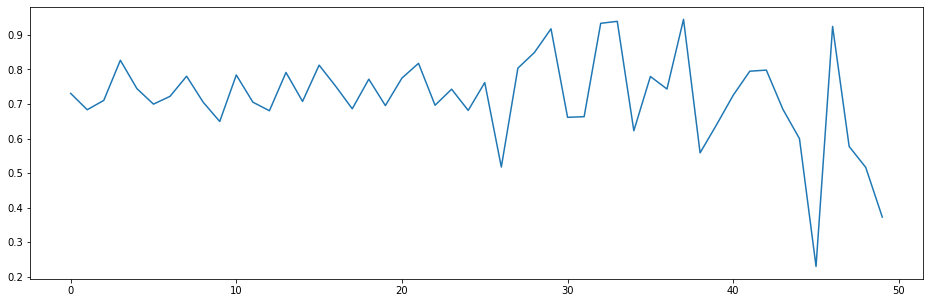

In [311]:
#plt.plot(Xtrn[-50:,0])
plt.plot(ytst[-50:,0])

In [312]:
tsParams1 = tsParams.copy()
tsParams2 = tsParams.copy()
tsParams2['batch_size'] =1

trng1 = TimeseriesGenerator(Xtrn, ytrn, **tsParams1 )
valg1 = TimeseriesGenerator(Xtst, ytst, **tsParams1 )
valg2 = TimeseriesGenerator(X, y, **tsParams2 )

history_points, tsParams1, len(trng1), len(valg1), len(valg2), #trng1[0]

(50,
 {'length': 50, 'batch_size': 1, 'stride': 1, 'sampling_rate': 1},
 4478,
 454,
 4982)

In [313]:
#-------------------------------------------------------------------------------------
def SimpleModel1(nfeatures, nOut, history_points):
    lstm_input = Input(shape=(history_points, nfeatures), name='lstm_input')
    x = LSTM(50, name='lstm_0')(lstm_input)
    x = Dropout(0.2, name='lstm_dropout_0')(x)
    x = Dense(64, name='dense_0')(x)
    x = Activation('sigmoid', name='sigmoid_0')(x)
    x = Dense(nOut, name='dense_1')(x)
    output = Activation('linear', name='linear_output')(x)

    model = Model(inputs=lstm_input, outputs=output)
    adam = optimizers.Adam(lr=0.0005)
    model.compile(optimizer=adam, loss='mse')
    
    return model

def plot(modelFile, valg, model=None, n=-150, howmany=50):
    m1 = model or load_model(modelFile)
    
    xxt = np.array([valg[i][0][0] for i in range(len(valg))])
    yyt = np.array([valg[i][1][0] for i in range(len(valg))])

    plt.gcf().set_size_inches(22, 10, forward=True)
    yh=m1.predict(xxt)
    plt.plot(yyt[n:n+howmany], marker='o', label="original")
    plt.plot( yh[n:n+howmany], marker='x', label="predicted")
    plt.title(f"{modelFile} <==")
    plt.legend()
    plt.show()
    
    return yyt, yh


In [447]:
from keras.callbacks import Callback
class ModelCheckpointSada(Callback):
    def __init__(self, filepath, monitor='val_loss', best=np.inf, 
                 stop_at=False, verbose=0, drawLoss=False):
        super(Callback, self).__init__()
        self.monitor  = monitor
        self.filepath = filepath
        self.verbose  = verbose
        self.best     = best or np.inf
        self.stop_at  = stop_at;
        self.history  = {}
        self.epochs   = []
        self.drawLoss = drawLoss
        
    def save_ext(self):
        with open(self.filepath+"_ext", "wb") as f:
            myParams = {
                'best' : self.best 
            }
            pickle.dump(myParams, f, protocol=pickle.HIGHEST_PROTOCOL)
                
    def load_ext(self):
        if ( not os.path.exists(self.filepath+"_ext")):
            return 
        with open(self.filepath+"_ext", "rb") as f:
            myParams = pickle.load(f)
        self.best = myParams['best']
        print(f"Best Loaded {self.best}")

    def drawLosses(self):
        history, best = self.history, self.best
        IPython.display.clear_output(wait=True)
        plt.clf()  
        for k, v in history.items():
            #print(k, v)
            plt.plot(  v, marker='v', label=f"{k}")

        plt.plot(0, best, marker="o",  c="g", label=f"BEST: {best}")
        plt.legend();
        plt.show()
    
    def on_epoch_end(self, epoch, logs={}):
        self.epochs.append(epoch)
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        self.current = logs.get(self.monitor)
        if self.current is None:
            warnings.warn(f'Can save best model only with {self.monitor} available')
            return;
                    
        if (self.best > self.current):
            ou= f'{self.monitor}: {self.best} > {self.current}\n'
            print(f"Epoch: {epoch+1} Saving: ou");
            self.best = self.current
            self.model.save(self.filepath, overwrite=True)
            save_ext();
            self.model.stop_training = self.stop_at
        elif self.verbose > 0:
            ou= f'{self.monitor}: {self.best} <= {self.current}'
            print(f"{epoch+1} din't improve : {ou}\r", end="")
            
        if (self.drawLoss):
            drawLosses(self.history, self.best)



In [448]:
validation_steps = 50
load=1
if ( load and os.path.exists(modelFile)):
    est= ModelCheckpointSada(modelFile, 'val_loss', best=np.inf, stop_at=False, 
                             verbose=1, drawLoss=False)
    est.load_ext()
    model_1 = load_model(est.filepath)
else:
    model_1 = SimpleModel1(Xtrn.shape[-1], ytrn.shape[-1], tsParams['length'])
model_1.summary()


Best Loaded 1.312402275743807e-08
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_input (InputLayer)      (None, 50, 5)             0         
_________________________________________________________________
lstm_0 (LSTM)                (None, 50)                11200     
_________________________________________________________________
lstm_dropout_0 (Dropout)     (None, 50)                0         
_________________________________________________________________
dense_0 (Dense)              (None, 64)                3264      
_________________________________________________________________
sigmoid_0 (Activation)       (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
_________________________________________________________________
linear_output (Activation

In [460]:
validation_steps, vv, ep=50, 0, 100
model_1.fit(trng1, verbose=vv, epochs=ep, validation_data=valg1,steps_per_epoch=200, shuffle=True, 
                    validation_steps=50, callbacks=[est])
est.best

1.312402275743807e-08

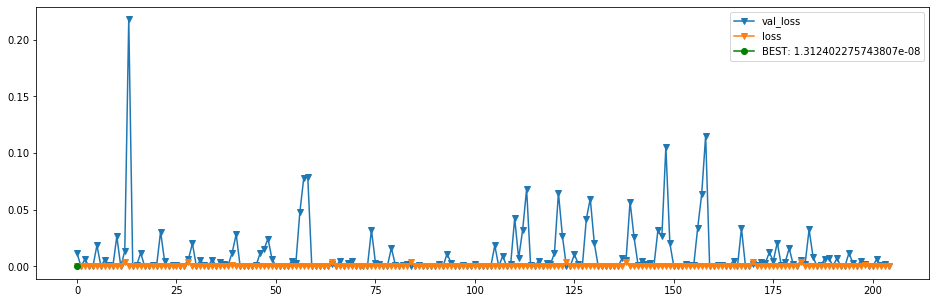

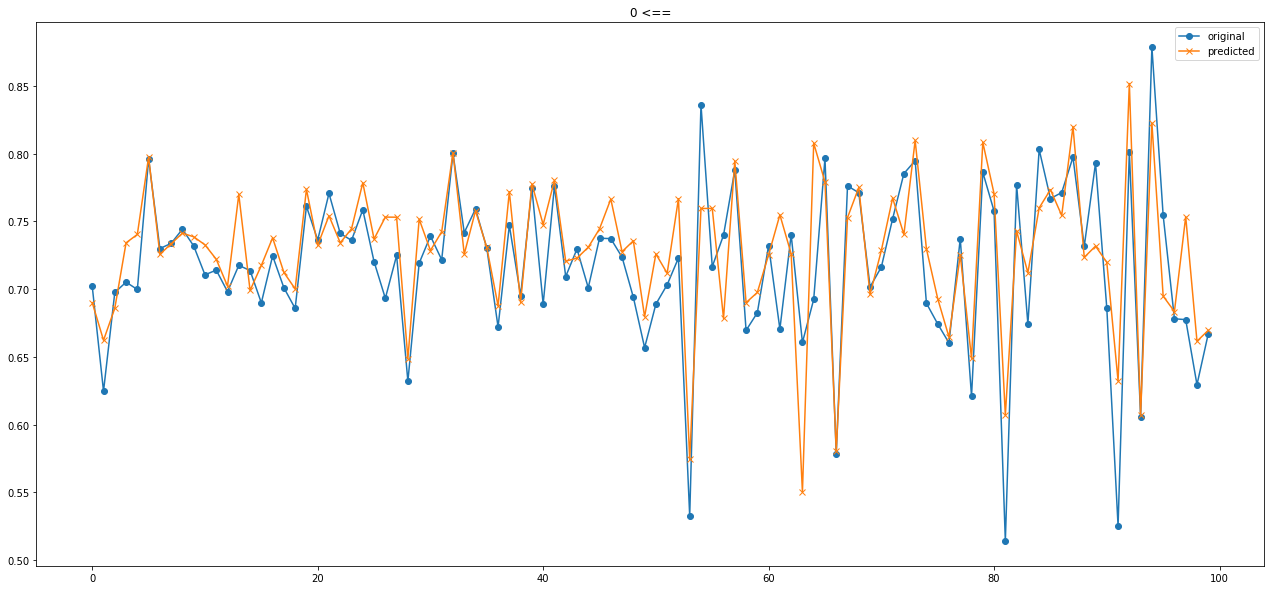

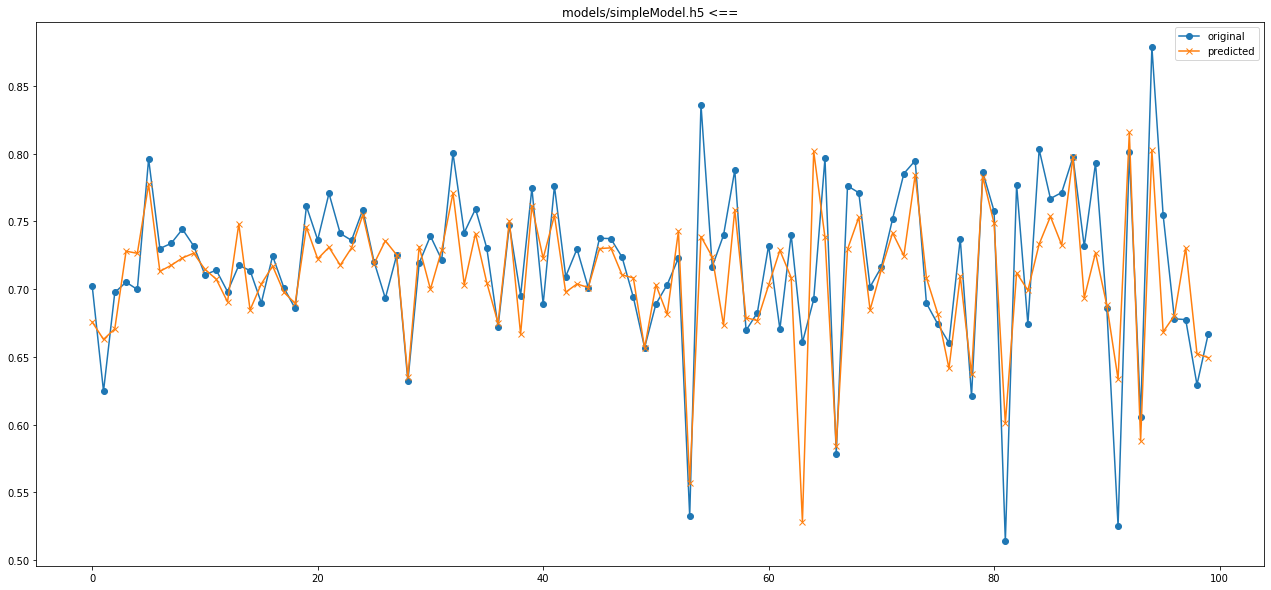

In [462]:
print(len(valg2), est.best)
est.drawLosses()
yo, yh = plot(0, valg2, model_1, -400,100);
plt.show()
yo, yh = plot(est.filepath, valg2, 0, -400,100);


# EXTENDED Stuff for Future

In [145]:
len(valg2), valg2[-2][1]

(4982, array([[0.74173028]]))

In [ ]:
# yoo = scalerY.inverse_transform(yo)
scalerY=getConfigObject(conf, "scalerYString")

yho = scalerY.inverse_transform(yh)
#yo1 = data[df.columns[-1]][-500:].values # <= original 

In [ ]:
fr,hm=-350, 250
#plt.plot(yo1[fr:fr+hm]    , marker='o', label="original")
#plt.plot(yoo[fr:fr+hm]+0.1, marker='x', label = "used for computing validation error")
plt.plot(yho[fr:fr+hm]    , marker='.', label = "predicted")
plt.legend()

In [ ]:
import numpy as np
from numpy.testing import assert_allclose
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import ModelCheckpoint

vec_size = 100
n_units = 10

x_train = np.random.rand(500, 10, vec_size)
y_train = np.random.rand(500, vec_size)

model = Sequential()
model.add(LSTM(n_units, input_shape=(None, vec_size), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(n_units, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(n_units))
model.add(Dropout(0.2))
model.add(Dense(vec_size, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')

# define the checkpoint
filepath = "model.h5"
cp1= ModelCheckpoint(filepath=filepath, monitor='loss',     save_best_only=True, verbose=1, mode='min')
callbacks_list = [cp1]

# fit the model
model.fit(x_train, y_train, epochs=5, batch_size=50, shuffle=True, validation_split=0.1, callbacks=callbacks_list)

# load the model
new_model = load_model(filepath)
#assert_allclose(model.predict(x_train),new_model.predict(x_train), 1e-5)
score = model.evaluate(x_train, y_train, batch_size=50)
cp1 = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
cp1.best = score

# fit the model
callbacks_list = [cp1]
new_model.fit(x_train, y_train, epochs=5, batch_size=50, callbacks=callbacks_list)

In [ ]:
# load the model
dd='/opt/LMCO/git/notebooks/no-git/NNBook/notebooks/NNetworks/LSTM/new'
m1 = load_model(f'{dd}/simple2-1.h5')
score = m1.evaluate(x_train, y_train, batch_size=50)
#cp1 = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
#cp1.best = score
score

In [ ]:
x_train.shape